# Welcome

This notebook serves as an example to how we can create neighbourhood boundaries in the context of cycling and walking as a mode of transportation for the any urban area. 

We begin with importing the necessary libraries and setting the location we want to find the neighbourhoods for. We also update OSMNx to ensure all the OSM tags we need are avaiable and ready. 

In [89]:
place = 'Copenhagen Municipality, Denmark'
manual_input = False # set to true if you want to use a polygon you've accessed yourself. You will need to set the location of this in the next section

In [90]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import LineString, Polygon
import requests
from shapely.ops import unary_union
from shapely import Polygon
from owslib.wms import WebMapService
from rasterio.mask import mask as rio_mask  
from rasterio.features import shapes
from shapely.geometry import shape, mapping
from rasterio.io import MemoryFile
import numpy as np
import matplotlib.colors as mcolors

# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )

C:\Users\b8008458\AppData\Local\Temp\ipykernel_61632\773111368.py:21: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


This project mostly uses OpenStreetMap data. As ever with OSM, you may need to edit this code to work best for your given location (speed limits, road classification etc). However it should be okay without any edits to get a basic example complete.

We first need to access the boundary of a location. If you wanted to use your own geopackage (or shapefile...), this is the cell to edit.

In [91]:
# get boundary
def set_location_boundary(place):
    """
    Sets up the location boundary by geocoding the given place and buffering it.

    Parameters:
    place (str): The name or address of the place to geocode.

    Returns:
    geopandas.GeoDataFrame: The buffered boundary of the location.
    """
    # Set location and get boundary
    boundary = ox.geocode_to_gdf(place)
    boundary = boundary.to_crs('3857') # we convert to EPSG 3857 to buffer in meters
    boundary_buffered = boundary.buffer(100) # Buffer boundary to prevent strange edge cases...

    return boundary_buffered, boundary

if manual_input == False:
    boundary_buffered, boundary = set_location_boundary(place)
else:
    boundary = gpd.read_file('data/example.geojson') # load your own polygon
    boundary = boundary.to_crs('3857') # set crs
    boundary_buffered = boundary.buffer(100)
    place = boundary

In [92]:
# check the boundary is correct
boundary.explore()

We can now get all of the bounding features for our neighbourhoods. This covers railways, rivers, busy bus routes, roads (based on road type), urban footprint and landuse. 

In [93]:
# lots of functions here, a bit of scrolling required!

def get_OSM_street_network(boundary_buffered):
    """
    Gets the street network from OpenStreetMap within the given boundary.

    Parameters:
    boundary_buffered (geopandas.GeoDataFrame): The buffered boundary of the location.

    Returns:
    all_streets networkx.MultiDiGraph: The street network.
    all_edges geopandas.GeoDataFrame: The edges of the street network.
    all_nodes geopandas.GeoDataFrame: The nodes of the street network.
    common_nodes_gdf: A GeoDataFrame containing the common nodes between the driving and walking street networks.
    """
     # Reset boundary_buffered crs for passing to OSM
    boundary_buffered_4326 = boundary_buffered.to_crs('4326')
    # Get street network
    all_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='all')
    # split into geodataframes
    all_edges = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)
    all_nodes = ox.graph_to_gdfs(all_streets, nodes=True, edges=False)
    # asign a crs in meters
    all_edges = all_edges.to_crs('3857')
    all_nodes = all_nodes.to_crs('3857')

    # we also get common nodes between networks to filter out areas with no streets later on
    walk_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='walk', simplify=True)
    drive_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='drive', simplify=False)
    walk_nodes = ox.graph_to_gdfs(walk_streets, nodes=True, edges=False)
    drive_nodes = ox.graph_to_gdfs(drive_streets, nodes=True, edges=False)
    common_nodes = drive_nodes.merge(walk_nodes, on='osmid', suffixes=('_drive', '_walk'))
    common_nodes_gdf = gpd.GeoDataFrame(common_nodes, geometry='geometry_drive')

    return all_streets, all_edges, all_nodes, common_nodes_gdf

all_streets, all_edges, all_nodes, common_nodes_gdf = get_OSM_street_network(boundary_buffered)

In [94]:

def retrieve_osm_features(polygon, tags):
    """
    Retrieves OpenStreetMap features based on the specified polygon and tags.

    Args:
        polygon (Polygon): The polygon to retrieve features within.
        tags (dict): The tags to filter the features.

    Returns:
        GeoDataFrame: The retrieved OpenStreetMap features.
    """
    try:
        features = ox.features_from_polygon(polygon=polygon, tags=tags)
    except Exception as e:
        error_message = str(e)
        if "There are no data elements in the server response" in error_message:
            print("No data elements found for the specified location/tags.")
            features = gpd.GeoDataFrame()  # Create an empty GeoDataFrame
        else:
            # Handle other exceptions here if needed
            print("An error occurred:", error_message)
            features = None
    return features


def get_railways(place):
    """
    This retrievies and processes OpenStreetMap (OSM) railways data for a specified place.

    Args:
        place (str): The name of the place to retrieve OSM features for.

    Returns:
        railways (geopandas.GeoDataFrame): A GeoDataFrame containing the railways within the specified place.
    """

    # for unknown reasons, using rail = ox.graph_from_place(place, custom_filter='["railway"]')
    # doesn't ALWAYS retrive the full rail network, hence why multiple lines are used to achive the same result

    # Define railway types to retrieve
    railway_types = ["", "rail", "light_rail", "narrow_gauge", "subway", "tram"]
    # Initialize an empty graph
    combined_railways = nx.MultiDiGraph()
    for railway_type in railway_types:
        try:
            if manual_input == False:# Fetch the railway network for the specified type
                network = ox.graph_from_place(place, simplify=False, custom_filter=f'["railway"~"{railway_type}"]')
                # Ensure the fetched network is a MultiDiGraph
                if not isinstance(network, nx.MultiDiGraph):
                    network = nx.MultiDiGraph(network)
            else:
                network = ox.graph_from_polygon(place.geometry.iloc[0], network_type='all', simplify=False)
                # Ensure the fetched network is a MultiDiGraph
                if not isinstance(network, nx.MultiDiGraph):
                    network = nx.MultiDiGraph(network)

        except Exception as e:
            print(f"No railway data found for '{railway_type}'.")
            network = nx.MultiDiGraph()

        # Compose the networks
        combined_railways = nx.compose(combined_railways, network)
    # Convert to GeoDataFrame
    railways = ox.graph_to_gdfs(combined_railways, nodes=False, edges=True)
    # Drop any other railway types that aren't needed
    railways = railways.loc[(~railways["railway"].isin(["tunnel", "abandoned", "razed", "disused", "funicular", "monorail", "miniature"]))]
    # Drop rows where any of the specified columns have values "True" or "yes"
    columns_to_check = ['tunnel', 'abandoned', 'razed', 'disused', 'funicular', 'monorail', 'miniature']
    railways = railways.loc[~railways[railways.columns.intersection(columns_to_check)].isin(['True', 'yes']).any(axis=1)]
    # Set railways CRS
    railways = railways.to_crs('EPSG:3857')

    return railways


def get_rivers(boundary_buffered):
    """
    Retrieves river features within a given boundary.

    Args:
        boundary_buffered (GeoDataFrame): A GeoDataFrame representing the buffered boundary.

    Returns:
        GeoDataFrame: A GeoDataFrame containing the river features within the boundary.
    """
    # reset boundary crs to allow for features to be found
    boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

    tags = {"waterway": ["river", "rapids"]}

    rivers = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)

    # Dropping rows where 'tunnel' is equal to 'culvert'
    if 'tunnel' in rivers.columns:
        rivers = rivers[rivers['tunnel'] != 'culvert']

    # set/reset crs
    rivers = rivers.to_crs('3857')
    boundary_buffered = boundary_buffered.to_crs('3857')

    return rivers


## get urban footprints from GUF

def get_guf(place):
    """
    Retrieves a clipped GeoDataFrame of GUF urban areas within a specified place boundary.

    Parameters:
    - place (str): The name or address of the place to retrieve urban areas for.

    Returns:
    - gdf_clipped (GeoDataFrame): A GeoDataFrame containing the clipped urban areas within the specified place boundary.
    """

    # Step 1: Access the WMS Service
    wms_url = 'https://geoservice.dlr.de/eoc/land/wms?GUF04_DLR_v1_Mosaic'
    wms = WebMapService(wms_url, version='1.1.1')

    # Step 2: Identify the Layer with ID 102. This is the Global Urban Footprint layer GUF
    for layer_name, layer in wms.contents.items():
        if '102' in layer_name:
            print(f"Layer ID 102 found: {layer_name}")

    # Assuming 'GUF04_DLR_v1_Mosaic' is the layer with ID 102
    layer = 'GUF04_DLR_v1_Mosaic'  # Replace with the actual layer name if different

    # Step 3: Get the polygon boundary using osmnx
    if manual_input == False:
        boundary_gdf = ox.geocode_to_gdf(place)
    else:
        boundary_gdf = place
    boundary = boundary_gdf.to_crs('EPSG:3857')
    # buffer boundary to ensure clips include riverlines which may act as borders between geographies
    boundary_buffered = boundary.buffer(100)
    boundary_buffered = boundary_buffered.to_crs('EPSG:4326')
    boundary_polygon = boundary_gdf.geometry[0]
    wms_boundary = boundary_buffered.geometry[0]

    # Convert the polygon to a bounding box
    minx, miny, maxx, maxy = wms_boundary.bounds

    # Step 4: Request the data from WMS using the bounding box
    width = 1024
    height = 1024
    response = wms.getmap(
        layers=[layer],
        srs='EPSG:4326',
        bbox=(minx, miny, maxx, maxy),
        size=(width, height),
        format='image/geotiff'
    )

    # Step 5: Load the Raster Data into Rasterio
    with MemoryFile(response.read()) as memfile:
        with memfile.open() as src:
            image = src.read(1)  # Read the first band
            transform = src.transform
            crs = src.crs

            # Clip the raster data to the polygon
            out_image, out_transform = rio_mask(src, [mapping(wms_boundary)], crop=True)  # Use renamed mask function
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "crs": crs})

    # Step 6: Convert Raster to Vector
    mask_arr = (out_image[0] != 0).astype(np.uint8)  # Assuming non-zero values are urban areas

    shapes_gen = shapes(mask_arr, mask=mask_arr, transform=out_transform)

    polygons = []
    for geom, value in shapes_gen:
        polygons.append(shape(geom))

    # Create a GeoDataFrame from the polygons
    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

    # Step 7: Create Buffers Around Urban Areas
    buffer_distance = 100  # Buffer distance in meters (adjust as needed)
    gdf_buffered = gdf.copy()
    gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)

    # Step 8: Clip the GeoDataFrame to the boundary of the place
    gdf_clipped = gpd.clip(gdf, boundary_gdf)

    return gdf_clipped

## get residential areas

def get_residential_areas(polygon):
    polygon = polygon.to_crs('EPSG:4326')
    # Retrieve features from OpenStreetMap
    features = ox.features_from_polygon(polygon.iloc[0], tags={'landuse': 'residential'})
    
    # Convert features to a GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(features)
    gdf = gdf.set_crs('EPSG:4326')
    
    return gdf




## join urban foot prints and residential areas
# this is to create a single polygon of where neighbourhoods can be found within

def join_geodataframes(gdf1, gdf2):
    # Ensure both GeoDataFrames have the exact same CRS
    target_crs = 'EPSG:4326'  # WGS 84
    gdf1 = gdf1.to_crs(target_crs)
    gdf2 = gdf2.to_crs(target_crs)
    
    # Concatenate GeoDataFrames
    joined_gdf = pd.concat([gdf1, gdf2], ignore_index=True)
    
    return gpd.GeoDataFrame(joined_gdf, crs=target_crs)





## create a small buffer to ensure all areas a captured correctly

def buffer_geometries_in_meters(gdf, distance):
    # Define the World Mercator projected CRS
    projected_crs = 'EPSG:3857'  # World Mercator

    # Project to the new CRS
    gdf_projected = gdf.to_crs(projected_crs)
    
    # Buffer the geometries
    gdf_projected['geometry'] = gdf_projected['geometry'].buffer(distance)
    
    # Reproject back to the original CRS
    gdf_buffered = gdf_projected.to_crs(gdf.crs)
    
    return gdf_buffered



## union into one gdf

def unary_union_polygons(gdf):
    # Combine all geometries into a single geometry
    unified_geometry = unary_union(gdf['geometry'])
    
    # Create a new GeoDataFrame with a single row containing the unified geometry
    combined_gdf = gpd.GeoDataFrame({'geometry': [unified_geometry]}, crs=gdf.crs)
    
    return combined_gdf



# Function to remove holes from neighbourhoods
def remove_holes(polygon):
    if polygon.geom_type == 'Polygon':
        return Polygon(polygon.exterior)
    else:
        return polygon





def get_landuse(boundary_buffered):
    """
    Retrieves the landuse features based on the specified boundary.

    Args:
        boundary_buffered (GeoDataFrame): The buffered boundary polygon.

    Returns:
        GeoDataFrame: The landuse features.
    """
    # reset boundary crs to allow for features to be found
    boundary_buffered = boundary_buffered.to_crs('EPSG:4326')
    # Define tags
    tags = {"landuse": ["industrial", "railway", "brownfield", "commercial", "farmland", "meadow"]}
    # Use ox.features_from_polygon to find features matching the specified tags
    landuse = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)
    # set/reset crs
    landuse = landuse.to_crs('3857')

    ## get unsuitable "nature" types
    # Define tags
    tags = {"natural": ["wood", "water", "scrub", "coastline", "beach"]}
    # Use ox.features_from_polygon to find features matching the specified tags
    nature = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)
    # set/reset crs
    nature = nature.to_crs('3857')

    ## get unsuitable "lesiure" types. This is mainly for golfcourses
    # Define tags
    tags = {"leisure": ["golf_course", "track", "park"]}
    # Use ox.features_from_polygon to find features matching the specified tags
    leisure = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)
    # set/reset crs
    leisure = leisure.to_crs('3857')
    # Define the tags for aeroway
    aeroway_tags = {"aeroway": ["aerodrome"]}
    # Use the function to retrieve aeroway features
    aeroway = retrieve_osm_features(polygon=boundary_buffered.iloc[0], tags=aeroway_tags)
    # Check if any features were retrieved
    if aeroway is not None:
        if not aeroway.empty:
            # set/reset crs
            aeroway = aeroway.to_crs('3857')

    # concat
    landuse = pd.concat([landuse, nature, leisure, aeroway])

    ## resest boundary crs
    boundary_buffered = boundary_buffered.to_crs('EPSG:3857')

    return landuse


def get_bus_routes(boundary_buffered):
        """
        Retrieves bus routes from OSM/NAPTAN within a given boundary.

        Args:
                boundary_buffered (GeoDataFrame): A GeoDataFrame representing the boundary.

        Returns:
                bus_routes (GeoDataFrame): A GeoDataFrame containing the bus routes.

        Raises:
                Exception: If there is an error fetching the data from the Overpass API.
        """
        # reset boundary crs to allow for features to be found
        boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

        # Calculate the bounding box for XML query
        bounding_box = boundary_buffered.bounds

        # Extract the minimum and maximum coordinates
        minx = bounding_box['minx'].min()
        miny = bounding_box['miny'].min()
        maxx = bounding_box['maxx'].max()
        maxy = bounding_box['maxy'].max()

        # Create a list of four elements representing the bounding box
        bbox = [minx, miny, maxx, maxy]

        # reset boundary_buffer crs
        boundary_buffered = boundary_buffered.to_crs('3857')

        # Define the Overpass API endpoint
        overpass_url = "https://overpass-api.de/api/interpreter"

        # Define the XML query
        xml_query = f"""
        <osm-script output="json" output-config="" timeout="160">
            <union into="_">
                <query into="_" type="node">
                    <has-kv k="route" modv="" v="bus"/>
                    <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
                </query>
                <query into="_" type="way">
                    <has-kv k="route" modv="" v="bus"/>
                    <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
                </query>
                <query into="_" type="relation">
                    <has-kv k="route" modv="" v="bus"/>
                    <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
                </query>
            </union>
            <print e="" from="_" geometry="full" ids="yes" limit="" mode="body" n="" order="id" s="" w=""/>
            <recurse from="_" into="_" type="down"/>
            <print e="" from="_" geometry="full" ids="yes" limit="" mode="skeleton" n="" order="quadtile" s="" w=""/>
        </osm-script>

        """

        # Initialize lists to store data
        geometries = []
        element_data = []

        # Make the Overpass API request
        response = requests.post(overpass_url, data=xml_query)

        # Check if the request was successful
        if response.status_code == 200:
                data = response.json()

                # Access the data from the response
                for element in data.get("elements", []):
                        if element.get('type') == 'way' and 'geometry' in element:
                                # Extract geometry coordinates from 'geometry' field
                                coordinates = [(node['lon'], node['lat']) for node in element['geometry']]
                                # Create a LineString geometry
                                line = LineString(coordinates)
                                geometries.append(line)
                                element_data.append(element)

                # Create a GeoDataFrame
                bus_routes = gpd.GeoDataFrame(element_data, geometry=geometries)

                # Set CRS
                bus_routes = bus_routes.set_crs('4326')
                bus_routes = bus_routes.to_crs('3857')

                return bus_routes

        else:
                raise Exception(f"Error fetching data: {response.status_code} - {response.text}")



def clip_boundaries(all_edges, rivers, railways, landuse, bus_routes, boundary_buffered):
    """
    Clips the geospatial data to the boundary_buffered extent.

    Parameters:
    - all_edges (GeoDataFrame): lines from OSM street network.
    - rivers (GeoDataFrame): lines of Rivers.
    - railways (GeoDataFrame): lines of Railways.
    - landuse (GeoDataFrame): Land use polygons.
    - bus_routes (GeoDataFrame): lines of bus routes.
    - boundary_buffered (GeoDataFrame): buffered boundary.

    Returns:
    - clipped versions of input geodataframes, aside from the bufferd boundary.
    """
    all_edges_clip = gpd.clip(all_edges, boundary_buffered)
    rivers_clip = gpd.clip(rivers, boundary_buffered)
    railways_clip = gpd.clip(railways, boundary_buffered)
    landuse_clip = gpd.clip(landuse, boundary_buffered)
    bus_routes_clip = gpd.clip(bus_routes, boundary_buffered)

    return all_edges_clip, rivers_clip, railways_clip, landuse_clip, bus_routes_clip


def process_bus_routes(bus_routes_clip, buffer_distance):
    """
    Count the number of bus routes per road and remove roads with more than one bus route on them.
    
    Args:
        bus_routes_clip (GeoDataFrame): The input GeoDataFrame containing bus routes.
        buffer_distance (float): The buffer distance to convert roads to polygons, set in meters.
    
    Returns:
        GeoDataFrame: The filtered GeoDataFrame containing roads with less than or equal to one bus route.
    """
    # Create a new GeoDataFrame with the buffered geometries
    bus_routes_buffered = bus_routes_clip.copy()  # Copy the original GeoDataFrame
    bus_routes_buffered['geometry'] = bus_routes_buffered['geometry'].buffer(buffer_distance)

    # count the number of overlapping bus routes
    def count_overlapping_features(gdf):
        """
        Count the number of overlapping features in a GeoDataFrame.
        
        Args:
            gdf (GeoDataFrame): The input GeoDataFrame.
        
        Returns:
            GeoDataFrame: The input GeoDataFrame with an additional column 'Bus_routes_count' indicating the count of overlapping features.
        """
        # Create an empty column to store the count of overlapping features
        gdf['Bus_routes_count'] = 0

        # Iterate through each row in the GeoDataFrame
        for idx, row in gdf.iterrows():
            # Get the geometry of the current row
            geometry = row['geometry']
            
            # Use a spatial filter to find overlapping features
            overlaps = gdf[gdf['geometry'].intersects(geometry)]
            
            # Update the Bus_routes_count column with the count of overlapping features
            gdf.at[idx, 'Bus_routes_count'] = len(overlaps)
        
        return gdf

    # call function
    bus_routes_buffered_with_count = count_overlapping_features(bus_routes_buffered)

    # drop any roads which have less than two bus routes on them
    bus_routes_filtered = bus_routes_buffered_with_count[bus_routes_buffered_with_count['Bus_routes_count'] >= 2]
    
    return bus_routes_filtered



def filter_OSM_boundary_roads(all_edges_clip):
    """
    Filter the `all_edges_clip` DataFrame to select boundary roads.

    This function filters the `all_edges_clip` DataFrame to select roads that are considered "boundary" roads. 
    The selection criteria include roads that have the following attributes:
    - `primary_route` is True
    - `trunk_road` is True
    - `fictitious` is True
    - `road_classification` is 'A Road' or 'B Road'
    - `road_function` is 'Minor Road' or 'Motorway'

    The filtered DataFrame is returned.

    Note: The commented line `(all_edges_clip['road_function'] == 'Restricted Local Access Road')` is excluded from the selection.

    Parameters:
    - all_edges_clip (DataFrame): A DataFrame containing road data.

    Returns:
    - boundary_roads (DataFrame): A DataFrame containing the filtered boundary roads.

    Example usage:
        # Assuming `all_edges_clip` is a DataFrame containing road data
        boundary_roads = filter_boundary_roads(all_edges_clip)
    """
    #boundary_roads = all_edges_clip.loc[((all_edges_clip['primary_route'] == 'True') |
    #                (all_edges_clip['trunk_road'] == 'True') |
     #               (all_edges_clip['fictitious'] == 'True') |
      #              (all_edges_clip['road_classification'] == 'A Road') | 
       #             (all_edges_clip['road_classification'] == 'B Road') | 
        #            (all_edges_clip['road_function'] == 'Minor Road') |
         #           (all_edges_clip['road_function'] == 'Motorway') |
          #          (all_edges_clip['road_function'] == 'Minor Road')  
           #         )]


    # Find "boundary" roads
    boundary_roads = all_edges_clip.loc[((all_edges_clip['highway'] == 'trunk') |
                            (all_edges_clip['highway'] == 'trunk_link') |
                            (all_edges_clip['highway'] == 'motorway') |
                            (all_edges_clip['highway'] == 'motorway_link') |
                            (all_edges_clip['highway'] == 'primary') |
                            (all_edges_clip['highway'] == 'primary_link') |
                            (all_edges_clip['highway'] == 'secondary') |
                            (all_edges_clip['highway'] == 'secondary_link') |
                            (all_edges_clip['highway'] == 'tertiary') |
                            (all_edges_clip['highway'] == 'tertiary_link') |
                            # speeds
                            (all_edges_clip['maxspeed'] == '60 mph') | 
                            (all_edges_clip['maxspeed'] == '70 mph') |
                            (all_edges_clip['maxspeed'] == '40 mph') |
                            (all_edges_clip['maxspeed'] == ('30 mph', '60 mph')) |
                            (all_edges_clip['maxspeed'] == ('30 mph', '50 mph')) |
                            (all_edges_clip['maxspeed'] == ('70 mph', '50 mph')) |
                            (all_edges_clip['maxspeed'] == ('40 mph', '60 mph')) |
                            (all_edges_clip['maxspeed'] == ('70 mph', '60 mph')) |
                            (all_edges_clip['maxspeed'] == ('60 mph', '40 mph')) |
                            (all_edges_clip['maxspeed'] == ('50 mph', '40 mph')) |
                            (all_edges_clip['maxspeed'] == ('30 mph', '40 mph')) |
                            (all_edges_clip['maxspeed'] == ('20 mph', '60 mph')) |
                            (all_edges_clip['maxspeed'] == ('70 mph', '40 mph')) |
                            (all_edges_clip['maxspeed'] == ('30 mph', '70 mph')) |
                            # combined queries
                            ((all_edges_clip['highway'] == 'residential') & (all_edges_clip['maxspeed'] == '30 mph'))
                            )]

    return boundary_roads



## buffering and dissolving functions
 
def buffer_and_dissolve(input_gdf):
    """
    Buffer and dissolve a GeoDataFrame.
    
    Args:
        input_gdf (GeoDataFrame): The input GeoDataFrame.
    
    Returns:
        GeoDataFrame: The buffered and dissolved GeoDataFrame.
    """
    # Buffer around boundaries
    buffered_gdf = input_gdf.copy()  # Create a copy to avoid modifying the original
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(5) # set a 5 meter buffer

    # Dissolve the geometries
    dissolved_geo = buffered_gdf.unary_union

    # Create a new GeoDataFrame with the dissolved geometry
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])

    # Set the CRS (Coordinate Reference System)
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf


def dissolve_gdf(input_gdf):
    # dissolve geometries
    dissolved_geo = input_gdf.unary_union
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf


def erase_boundary_features(boundary, boundary_rivers_bd, boundary_roads_bd, boundary_rail_bd, boundary_landuse_bd, boundary_bus_routes_bd):
    """
    Erases boundary features from the given boundary geometry.

    Parameters:
    - boundary: GeoDataFrame representing the boundary geometry
    - boundary_rivers_bd: GeoDataFrame representing the rivers boundary features
    - boundary_roads_bd: GeoDataFrame representing the roads boundary features
    - boundary_rail_bd: GeoDataFrame representing the rail boundary features
    - boundary_landuse_bd: GeoDataFrame representing the landuse boundary features
    - boundary_bus_routes_bd: GeoDataFrame representing the bus routes boundary features

    Returns:
    - erased_boundary_gdf: GeoDataFrame containing the result of the "Erase" operation
    """

    # Join all boundary features
    boundaries = pd.concat([boundary_rivers_bd, boundary_roads_bd, boundary_rail_bd, boundary_landuse_bd, boundary_bus_routes_bd], ignore_index=True)
    boundary_features = dissolve_gdf(boundaries)

    # Use the `difference` method to perform the "Erase" operation
    erased_boundary = boundary.difference(boundary_features.unary_union)

    # Convert the GeoSeries to a single geometry using unary_union
    erased_boundary = erased_boundary.unary_union

    # Create a new GeoDataFrame with the result of "Erase" operation
    erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

    # Explode multipolygon to polygons
    erased_boundary_gdf = erased_boundary_gdf.explode()

    return erased_boundary_gdf


def drop_large_or_small_areas(neighbourhoods):
    """
    Drops rows from the 'neighbourhoods' DataFrame where the area is less than 10,000 square units or greater than 5,000,000 square units.

    Parameters:
    - neighbourhoods (DataFrame): The input DataFrame containing neighbourhood data.

    Returns:
    - neighbourhoods (DataFrame): The updated DataFrame with small areas dropped.
    """
    # Calculate area
    neighbourhoods["area"] = neighbourhoods.geometry.area

    # Drop rows where area is less than 10,000 or greater than 5,000,000
    neighbourhoods = neighbourhoods.loc[(neighbourhoods["area"] >= 10000)]
    neighbourhoods = neighbourhoods.loc[(neighbourhoods["area"] <= 5000000)]

    return neighbourhoods


def filter_neighbourhoods_by_roads(neighbourhoods, all_edges_clip, polygon_column_name):
    """
    Count the number of roads within each polygon in a GeoDataFrame and filter the neighbourhoods based on road count and road density.
    
    Args:
        neighbourhoods (GeoDataFrame): GeoDataFrame containing neighbourhood polygons.
        all_edges_clip (GeoDataFrame): GeoDataFrame containing road data.
        polygon_column_name (str): Name of the column in neighbourhoods to use for grouping.

    Returns:
        GeoDataFrame: Updated neighbourhoods GeoDataFrame with filtered rows based on road count and road density.
    """
    
    def count_roads_within_polygons(polygons_gdf, roads_gdf, polygon_column_name):
        """
        Count the number of roads within each polygon in a GeoDataFrame.
        
        Args:
            polygons_gdf (GeoDataFrame): GeoDataFrame containing polygons.
            roads_gdf (GeoDataFrame): GeoDataFrame containing roads.
            polygon_column_name (str): Name of the column in polygons_gdf to use for grouping.

        Returns:
            GeoDataFrame: Original polygons GeoDataFrame with a "road_count" column added.
        """
        
        # spatial join
        joined = gpd.sjoin(polygons_gdf, roads_gdf, how='left', op='intersects')
        
        # Group by the polygon column and count the number of roads in each
        road_counts = joined.groupby(polygon_column_name).size().reset_index(name='road_count')
        
        # Merge the road counts back into the polygons GeoDataFrame
        polygons_gdf = polygons_gdf.merge(road_counts, on=polygon_column_name, how='left')

        # Calculate road density (area divided by road_count). It is multiplied by 10000 for ease of understanding the numbers involved with this
        polygons_gdf['road_density'] = (polygons_gdf['road_count'] / polygons_gdf['area'] ) * 10000
        
        return polygons_gdf
    
    neighbourhoods = count_roads_within_polygons(neighbourhoods, all_edges_clip, polygon_column_name)

    # Drop rows with road_density below 0.2 or less than 4 roads
    neighbourhoods = neighbourhoods[(neighbourhoods['road_count'] > 2)]
    neighbourhoods = neighbourhoods[(neighbourhoods['road_density'] > 0.2)]
    
    return neighbourhoods


def remove_holes(polygon):
    """
    Removes holes from a polygon. Mostly for visual reasons.

    Parameters:
    polygon (Polygon): The polygon to remove holes from.

    Returns:
    Polygon: The polygon without holes.
    """
    if polygon.geom_type == 'Polygon':
        return Polygon(polygon.exterior)
    else:
        return polygon

landuse = get_landuse(boundary_buffered)
rivers = get_rivers(boundary_buffered)
guf = get_guf(place)
residential_areas = get_residential_areas(boundary_buffered)

guf_residential_gdf = join_geodataframes(guf, residential_areas)
guf_residential_gdf = buffer_geometries_in_meters(guf_residential_gdf, 100)  # Buffer by 100 meters
guf_residential_gdf = unary_union_polygons(guf_residential_gdf)
# set to BNG
guf_residential_gdf = guf_residential_gdf.to_crs("3857")
# remove holes from urban footprint
guf_residential_gdf['geometry'] = guf_residential_gdf['geometry'].apply(remove_holes)
railways = get_railways(place)
landuse = get_landuse(boundary_buffered)
bus_routes = get_bus_routes(boundary_buffered)
all_edges_clip, rivers_clip, railways_clip, landuse_clip, bus_routes_clip = clip_boundaries(all_edges, rivers, railways, landuse, bus_routes, boundary_buffered)
bus_routes_clip = process_bus_routes(bus_routes_clip, 0.2)
boundary_roads = filter_OSM_boundary_roads(all_edges_clip)

## buffer and dissolve 
boundary_roads_bd = buffer_and_dissolve(boundary_roads)
boundary_rivers_bd = buffer_and_dissolve(rivers_clip)
boundary_rail_bd = buffer_and_dissolve(railways_clip)
boundary_landuse_bd = buffer_and_dissolve(landuse_clip)
boundary_bus_routes_bd = buffer_and_dissolve(bus_routes_clip)



## geodataframe cleaning
# ensure that neighbourhoods fall only within urban footprint areas
boundary = gpd.clip(boundary, guf_residential_gdf)
erased_boundary_gdf = erase_boundary_features(boundary, boundary_rivers_bd, boundary_roads_bd, boundary_rail_bd, boundary_landuse_bd, boundary_bus_routes_bd)
neighbourhoods = erased_boundary_gdf
neighbourhoods = drop_large_or_small_areas(neighbourhoods)

neighbourhoods = filter_neighbourhoods_by_roads(neighbourhoods, all_edges_clip, 'geometry')

## create unique IDs
# simple number based ID
neighbourhoods['ID'] = range(1, len(neighbourhoods) + 1)

neighbourhoods['geometry'] = neighbourhoods['geometry'].apply(remove_holes)


## filter neighbourhoods to only locations with more than 1 intersection (1 or fewer intersections indicates that all travel modes will be the same)
# reset neighbourhoods crs
neighbourhoods = neighbourhoods.to_crs('4326')
# Spatial join to count points within each neighborhood
spatial_join = gpd.sjoin(neighbourhoods, common_nodes_gdf, how='left', op='contains')
# Group by 'ID' and count the points within each neighborhood
point_counts = spatial_join.groupby('ID').size().reset_index(name='point_count')
# Filter out neighborhoods with 1 or 0 points
filtered_neighbourhood_ids = point_counts[point_counts['point_count'] > 1]['ID']
neighbourhoods= neighbourhoods[neighbourhoods['ID'].isin(filtered_neighbourhood_ids)]



## we also need to join the length of the streets within the neighbourhood for further analysis
# Reset index of neighbourhoods
neighbourhoods = neighbourhoods.reset_index(drop=True)

# reset neighbourhoods crs
neighbourhoods = neighbourhoods.to_crs('3857')

# Perform a spatial join
joined_data = gpd.sjoin(all_edges_clip, neighbourhoods, how="inner", op="intersects")

# Group by neighborhood and calculate total road length
road_lengths = joined_data.groupby('index_right')['length'].sum().reset_index()

# Merge road_lengths with neighbourhoods and drop 'index_right' column
neighbourhoods = neighbourhoods.merge(road_lengths, left_index=True, right_on='index_right', how='left').drop(columns=['index_right'])

# Rename the column
neighbourhoods.rename(columns={'length': 'road_lengths'}, inplace=True)


C:\Users\b8008458\AppData\Local\Temp\ipykernel_61632\1263569533.py:186: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)


No railway data found for 'narrow_gauge'.
No railway data found for 'tram'.


C:\Users\b8008458\AppData\Local\Temp\ipykernel_61632\1263569533.py:630: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()
C:\Users\b8008458\AppData\Local\Temp\ipykernel_61632\1263569533.py:754: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  neighbourhoods = filter_neighbourhoods_by_roads(neighbourhoods, all_edges_clip, 'geometry')
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\co

In [95]:
## check neighbourhoods look good
neighbourhoods.explore()

Now we can join the neighbourhood ID to all the streets within each neighbourhood. This allows you to pull out either only neighbourhood streets or only

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


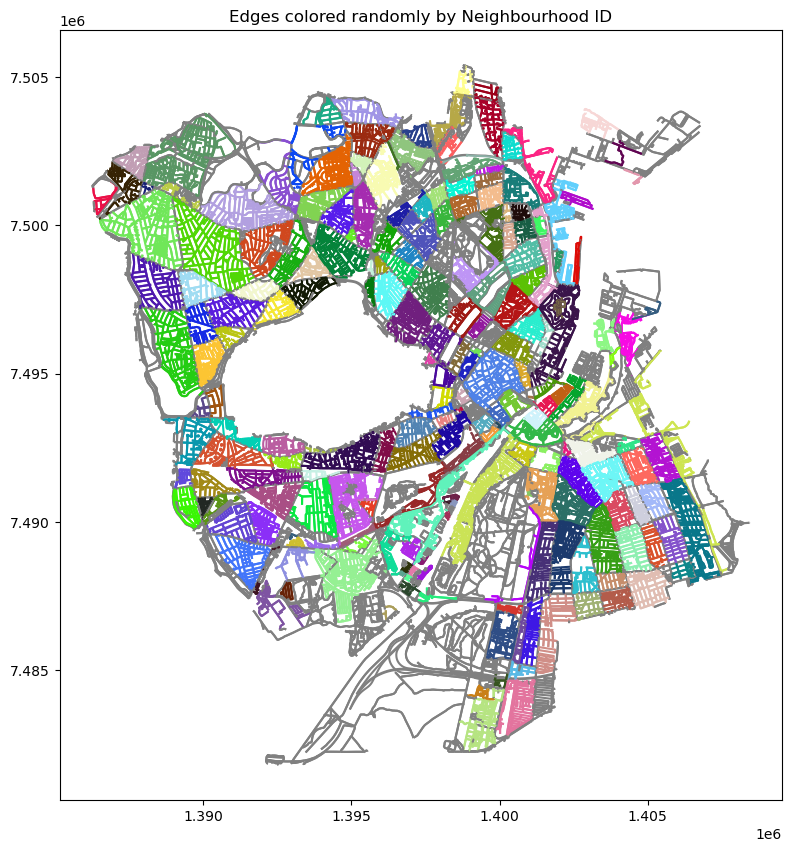

In [96]:
edges_with_neighbourhoods = gpd.sjoin(all_edges, neighbourhoods[['ID', 'geometry']], how="left", op="intersects")

## plot neighbourhood streets to make sure that things look okay
unique_ids = edges_with_neighbourhoods['ID'].dropna().unique()
np.random.seed(42) 
random_colors = {ID: mcolors.to_hex(np.random.rand(3)) for ID in unique_ids}
edges_with_neighbourhoods['color'] = edges_with_neighbourhoods['ID'].map(random_colors)
edges_with_neighbourhoods['color'] = edges_with_neighbourhoods['color'].fillna('#808080')  # Gray for NaN values
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_with_neighbourhoods.plot(ax=ax, color=edges_with_neighbourhoods['color'], legend=False) 
ax.set_title('Edges colored randomly by Neighbourhood ID')
plt.show()


And finaly we can export the neighbourhoods 

In [97]:
## export neighbourhoods

# send to geopackage 
geometry_column = neighbourhoods.geometry.name

# Iterate through the columns and convert them to strings

for column in neighbourhoods.columns:
    if column != geometry_column:
        neighbourhoods[column] = neighbourhoods[column].astype(str) # change to handle numbers
neighbourhoods.to_file(r'C:\Users\example\neighbourhoods.gpkg', driver="GPKG")

DriverError: sqlite3_open(C:\Users\example\neighbourhoods.gpkg) failed: unable to open database file